<a href="https://colab.research.google.com/github/juliasliu/info159/blob/main/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [2]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [3]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/test.txt

--2022-02-03 05:55:57--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2022-02-03 05:55:58 (22.2 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2022-02-03 05:55:58--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.

In [4]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [5]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [6]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [7]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [8]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words|Each key is the unique word that is present in the document. <br>For example, feats["hello"] contains the number of occurrences of the word "hello." <br>This works because it stores all the occurrences of unique words.|0.771
|Feature 1|The feature vector contains the number of occurrences of numbers and words. <br>For example, feats["numbers"] contains the number of numbers in the document. <br>This works because it tracks the number of numbers versus words.|0.549
|Feature 2|The feature vector contains the number of occurrences of capital words and lettercase words. <br>For example, feats["capital words"] contains the number of words with all uppercase letters. <br>This works because it tracks the number of capital versus lowercase words.|0.524
|Feature 3|Each key is the number of characters present in the document. <br>For example, feats[3] contains the total number of words that have a length of 3 characters. <br>This works because it stores all the occurrences of specific lengths of words.|0.562

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [16]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}

    words = nltk.word_tokenize(text)

    for word in words:
      word=word.lower()
      feats[word] = 1

    return feats

In [17]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 21224, Train accuracy: 1.000, Dev accuracy: 0.771


In [49]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}

    words = nltk.word_tokenize(text)

    feats["numbers"] = 0
    feats["words"] = 0
    for word in words:
      word=word.lower()
      if word.isdigit():
        feats["numbers"] += 1
      else:
        feats["words"] += 1
               
    return feats


In [50]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.549


In [47]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}

    words = nltk.word_tokenize(text)

    feats["capital_words"] = 0
    feats["lowercase_words"] = 0
    for word in words:
      if word.isupper():
        feats["capital_words"] += 1
      else:
        feats["lowercase_words"] += 1
               
    return feats

In [48]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 2, Train accuracy: 0.545, Dev accuracy: 0.524


In [45]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}

    words = nltk.word_tokenize(text)

    for word in words:
      word=word.lower()
      if len(word) in feats:
        feats[len(word)] += 1
      else:
        feats[len(word)] = 0
               
    return feats

In [46]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 39, Train accuracy: 0.581, Dev accuracy: 0.562


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [51]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [52]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Method: combiner_function, Features: 21265, Train accuracy: 1.000, Dev accuracy: 0.777


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


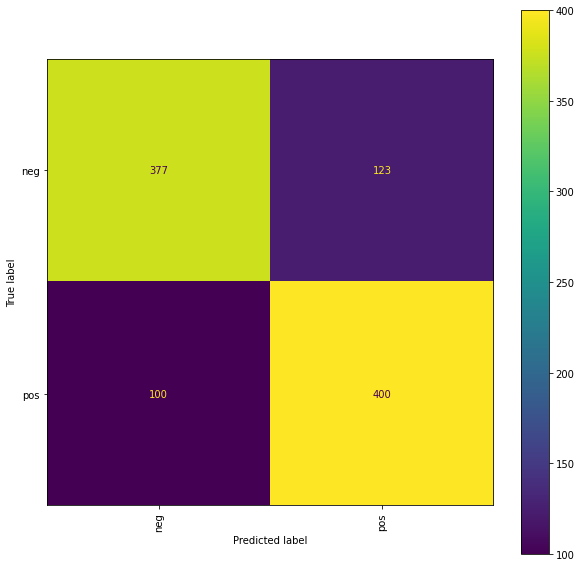

In [53]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [54]:
big_classifier.printWeights(n=25)

pos	0.920	great
pos	0.757	very
pos	0.703	excellent
pos	0.621	fun
pos	0.616	enjoyed
pos	0.595	simple
pos	0.575	amazing
pos	0.551	relationship
pos	0.526	top
pos	0.515	man
pos	0.502	best
pos	0.498	my
pos	0.497	perfect
pos	0.491	saw
pos	0.470	incredible
pos	0.469	takes
pos	0.447	true
pos	0.437	gets
pos	0.435	new
pos	0.435	you
pos	0.434	thought
pos	0.427	late
pos	0.424	definitely
pos	0.421	seen
pos	0.419	beautifully

neg	-1.170	worst
neg	-0.865	acting
neg	-0.754	would
neg	-0.739	boring
neg	-0.709	stupid
neg	-0.697	waste
neg	-0.649	idea
neg	-0.649	watching
neg	-0.640	even
neg	-0.603	?
neg	-0.598	money
neg	-0.592	poor
neg	-0.591	instead
neg	-0.551	there
neg	-0.541	awful
neg	-0.535	bad
neg	-0.533	horrible
neg	-0.515	me
neg	-0.493	actors
neg	-0.483	worse
neg	-0.482	maybe
neg	-0.481	killer
neg	-0.481	silly
neg	-0.480	poorly
neg	-0.476	something



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [55]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [56]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,0.999996,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1822,0.995084,pos,neg,"Zombi 3 has an interesting history in it's making. Firstly, it is a sequel to Fulci's hit Zombi 2, with Zombi 2 itself being of course a marketing ploy to trick people into thinking it was a sequel to George A. Romero's Dawn of the Dead aka Zombi. Confusing enough? Basically, none of the films have anything to do with one another, but who cares when they make money. I guess Fulci himself start..."
2,1659,0.994538,pos,neg,"Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly', one film moved me to want to actually see a change in international laws. The other felt like a poor attempt at making me cry fo..."
3,1608,0.994281,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling""is an everyday story of royal folk in late nineteenth century Austria.Set during one of Europe's seemingly incessant internal turmoils it concerns itself with the Emperor Franz Joseph (Mr James Mason),his rebellious son,the Crown Prince Rudolf (Mr Omar Sharif)the Empress(Miss Ava Gardner) and various mistresses,secret ..."
4,1784,0.993662,pos,neg,"The only complaint I have about this adaptation is that it is sexed-up. Things that were only hinted at in the novel are shown on-screen for some weird reason. Did they think the audience would be too stupid to understand if they were not shown everything out-right? Other than that, this is very good-quality. All the actors do marvelous jobs bringing their characters to life. For the shallow w..."
5,1456,0.993078,pos,neg,"Hardly a masterpiece. Not so well written. Beautiful cinematography i think not. This movie wasn't too terrible but it wasn't that much better than average. The main story dealing with highly immoral teens should have focused more on the forbidden romance and why this was... should have really gotten into it instead of scraping the surface with basically ""because mom says we can't."" Some parts..."
6,1726,0.990977,neg,pos,"I gave this movie a 2, and though I consider myself a science fiction fan, I found this movie very difficult to take seriously. It was on AMC one late night, and I'm glad I saw it for free. This movie is probably good for a few laughs, but not much more.The special effects are about average for the time period - not awful, but not great, either. Of course we know more about Mars now than we di..."
7,1043,0.988414,pos,neg,Some bad reviews here for this and I understand why but treat it as a low budget serial killer film and you might get more from it than most.I thought that this worked in a way because afterwards I felt dirty and wanted to take a long shower so that is some degree of success isn't it?I would say there is just the right level of sleaze here to get under your skin although the acting is maybe a ...
8,1833,0.987231,neg,pos,"This was yet another big screen outing for a US TV show from the sixties It is amusing enough but was very much to formula. Intelligent Martian lands on Earth and meets the not too bright humans, in his view.The usual wackiness ensues with the human, Bridges, eventually bonds with him and helps him to get home. Along the way he also gets the girl, Hannah.This is a nice outing for some pleasant..."
9,1916,0.986392,neg,pos,"Having read the other comments on this film, I would like to share my own view 